<a href="https://colab.research.google.com/github/vishal-anand-max/FiniteVolumeSolver/blob/main/HeatTransfer_FVM_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Finite Volume Solver for a Glass Conveyor Belt

## Physical Problem Setup
We are analyzing the heat transfer within a solid glass slab moving on a conveyor belt in a factory. The analysis focuses on a specific, fixed Control Volume (CV) on the conveyor.

* **Flow & Heat Sink (x-direction):** Glass enters the control volume at temperature $T_i$ and leaves at $T_f$. Its mass flow rate is given by $\dot{m}$ and specific heat is given by $C_p$. Rather than modeling the $x$-direction explicitly, this sensible heat loss is treated as a volumetric heat source/sink within the CV.
* **Conduction (y-direction):** The primary temperature gradient is evaluated across the thickness of the glass (the $y$-axis direction), which has a total thickness of $H$. The control volume length is $L$ and width is $w$.
* **Boundary Conditions:** The ambient temperature around the top surface is $T_1$, while the ambient temperature at the bottom surface is $T_2$ Heat transfers via convection to these ambients.

The ultimate goal of this analysis is to find the steady-state temperature distribution across the thickness of the glass

Please see the figure below for the schematic for set up.

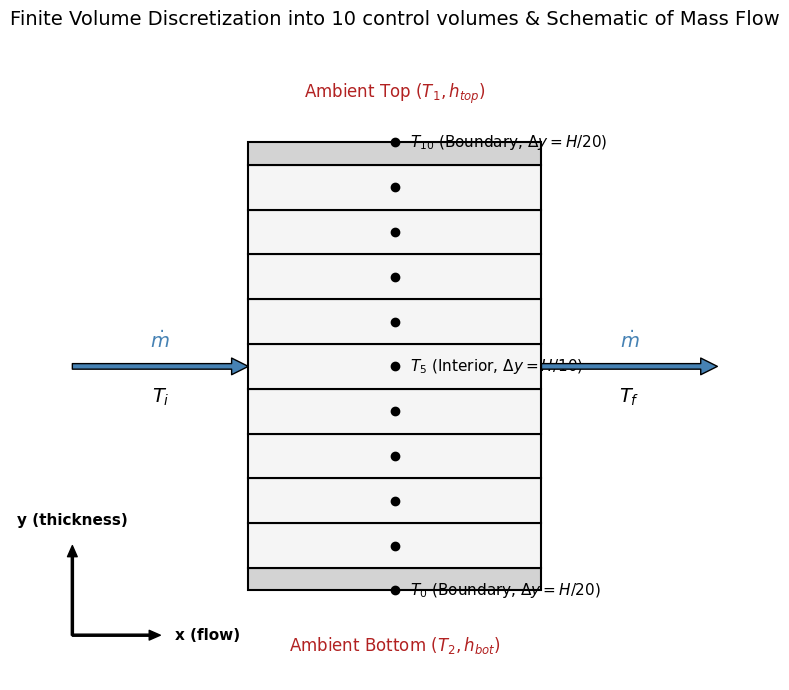

In [1]:
# @title
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Schematic Parameters ---
H = 0.05       # Total thickness (m)
N = 10         # Number of intervals
dy = H / N     # Standard interval size
y_nodes = np.linspace(0, H, N + 1)

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xlim(-0.8, 1.8)
ax.set_ylim(-0.01, H + 0.01)
ax.axis('off')
ax.set_title("Finite Volume Discretization into 10 control volumes & Schematic of Mass Flow", fontsize=14, pad=20)

# --- Draw Control Volumes ---
for i in range(N + 1):
    y_bottom = y_nodes[i] - (dy/2 if i > 0 else 0)
    height = dy/2 if (i == 0 or i == N) else dy

    # Draw CV box
    face_color = 'lightgray' if (i == 0 or i == N) else 'whitesmoke'
    rect = patches.Rectangle((0.0, y_bottom), 1.0, height, linewidth=1.5,
                             edgecolor='black', facecolor=face_color)
    ax.add_patch(rect)

    # Draw Nodes
    ax.plot(0.5, y_nodes[i], 'ko', markersize=6)

    # Node Labels
    if i == 0:
        label = r"$T_0$ (Boundary, $\Delta y=H/20$)"
    elif i == N:
        label = r"$T_{10}$ (Boundary, $\Delta y=H/20$)"
    elif i == N//2:
        label = r"$T_5$ (Interior, $\Delta y=H/10$)"
    else:
        label = ""

    if label:
        ax.text(0.55, y_nodes[i], label, va='center', fontsize=11)

# --- Draw Flow Arrows (x-direction) ---
# Inlet Arrow
ax.annotate('', xy=(0.0, H/2), xytext=(-0.6, H/2),
            arrowprops=dict(facecolor='steelblue', width=4, headwidth=12))
ax.text(-0.3, H/2 + 0.002, r'$\dot{m}$', fontsize=14, ha='center', color='steelblue')
ax.text(-0.3, H/2 - 0.004, r'$T_i$', fontsize=14, ha='center')

# Outlet Arrow
ax.annotate('', xy=(1.6, H/2), xytext=(1.0, H/2),
            arrowprops=dict(facecolor='steelblue', width=4, headwidth=12))
ax.text(1.3, H/2 + 0.002, r'$\dot{m}$', fontsize=14, ha='center', color='steelblue')
ax.text(1.3, H/2 - 0.004, r'$T_f$', fontsize=14, ha='center')

# --- Draw Ambient Labels ---
ax.text(0.5, H + 0.005, r"Ambient Top ($T_1, h_{top}$)", ha='center', fontsize=12, color='firebrick')
ax.text(0.5, -0.005, r"Ambient Bottom ($T_2, h_{bot}$)", ha='center', va='top', fontsize=12, color='firebrick')

# --- Draw Coordinate Axes (CAE Style) ---
origin_x, origin_y = -0.6, -0.005
arrow_len_x, arrow_len_y = 0.3, 0.01

# X-axis (Flow)
ax.annotate('', xy=(origin_x + arrow_len_x, origin_y), xytext=(origin_x, origin_y),
            arrowprops=dict(facecolor='black', width=1.5, headwidth=7, headlength=8))
ax.text(origin_x + arrow_len_x + 0.05, origin_y, 'x (flow)', va='center', ha='left', fontsize=11, fontweight='bold')

# Y-axis (Thickness)
ax.annotate('', xy=(origin_x, origin_y + arrow_len_y), xytext=(origin_x, origin_y),
            arrowprops=dict(facecolor='black', width=1.5, headwidth=7, headlength=8))
ax.text(origin_x, origin_y + arrow_len_y + 0.002, 'y (thickness)', va='bottom', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Finite Volume Discretization

We discretize the 1D domain across the thickness ($H$) into $N=10$ intervals using a vertex-centered approach, resulting in 11 total nodes



* **Interior Nodes (9 total):** These represent full control volumes of thickness $H/10$.
* **Boundary Nodes (2 total):** The top and bottom surfaces ($T_{s1}$ and $T_{s2}$) are modeled as "half-volumes" of thickness $H/20$. This ensures that our boundary conditions are applied exactly at the physical surfaces.

### 1. The Interior Nodes
The total thermal energy extracted by the flow is $\dot{S} = \dot{m}C_p(T_i - T_f)$.
For a standard interior control volume, the energy balance equates the local flow extraction (the source) to the net conduction between neighboring nodes.

Rearranging this into our linear system formulation $[A][x] = [b]$ yields the discrete equation for an interior node $T_i$:
$$\frac{\dot{S}}{10} = -\frac{20kA}{H}T_i + \frac{10kA}{H}T_{i+1} + \frac{10kA}{H}T_{i-1}$$



### 2. The Boundary Nodes
The boundary nodes are half-volumes ($H/20$), meaning they only receive half the source term ($\dot{S}/20$). They exchange heat via conduction with their single interior neighbor (at a distance of $H/10$) and via convection with the ambient environment.



**Bottom Boundary ($T_{s2}$):**
The energy balance accounts for convection from ambient $T_2$ and conduction from the first interior node ($T_1$)[cite: 1286]. Setting the incoming heat fluxes and the source term on the left, and the nodal temperature coefficient on the right:
$$\frac{\dot{S}}{20} + hAT_2 + \frac{10kA}{H}T_1 = \left(hA + \frac{10kA}{H}\right)T_{s2}$$

**Top Boundary ($T_{s1}$):**
Similarly, the top boundary accounts for convection from ambient $T_{amb1}$ and conduction from the adjacent interior node ($T_9$)[cite: 1296]. *(Note: We use $T_{amb1}$ here to distinguish from the interior node index $T_1$)*:
$$\frac{\dot{S}}{20} + hAT_{amb1} + \frac{10kA}{H}T_9 = \left(hA + \frac{10kA}{H}\right)T_{s1}$$

### Object-Oriented Solver Architecture
To solve this systematically without hardcoding a massive matrix by hand, we map the physics to a commercial-grade Object-Oriented architecture:
1. **Mesh & Geometry:** Immutable classes that define the spatial discretization ($H/10$ and $H/20$ volumes).
2. **Field:** A passive array storing the temperature $T$.
3. **Operators:** The `DiffusionOperator` populates the matrix with the $\frac{10kA}{H}$ conduction terms, while the `ConveyorSourceOperator` populates the RHS vector with the volumetric portion of $\dot{S}$.
4. **Boundary Conditions:** `ConvectionBC` objects enforce the Robin boundaries (the $hA$ terms) at the $H/20$ surface nodes seamlessly.


**Please note that since we are modeling Stefan Boltzmann's law of radiative flux, all temperatures must be in Kelvin**

In [4]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# --- Linear System Abstraction ---
class LinearSystem:
    """Encapsulates the complexity of building a sparse matrix."""
    def __init__(self, n):
        self.n = n
        self.rows, self.cols, self.data = [], [], []
        self.rhs = np.zeros(n)

    def add_A(self, i, j, v):
        self.rows.append(i)
        self.cols.append(j)
        self.data.append(v)

    def add_b(self, i, v):
        self.rhs[i] += v

    def to_csr(self):
        A = sp.coo_matrix((self.data, (self.rows, self.cols)), shape=(self.n, self.n))
        return A.tocsr(), self.rhs

# --- Topology & Geometry ---
class Mesh1D:
    """1D Topology defining connectivity (Who is my neighbor?)."""
    def __init__(self, N, H):
        self.N = N
        self.H = H
        self.Nc = N + 1  # 11 nodes for 10 intervals

    def neighbors(self, P):
        bottom = P - 1 if P > 0 else -1
        top = P + 1 if P < self.N else -1
        return bottom, top

    def boundary_cells(self, side):
        if side == "bottom": return [0]
        if side == "top": return [self.N]
        raise ValueError(f"Unknown side: {side}")

class Geometry1D:
    """Frozen geometry metrics (Volumes, Areas, Distances)."""
    def __init__(self, mesh, w, L):
        self.mesh = mesh
        self.A = w * L
        self.dy = mesh.H / mesh.N

        # Initialize volumes (interior = full, boundaries = half)
        self.V = np.full(mesh.Nc, self.A * self.dy)
        self.V[0] = self.A * self.dy / 2.0
        self.V[mesh.N] = self.A * self.dy / 2.0
        self.y = np.linspace(0, mesh.H, mesh.Nc)

# --- Passive Data & Properties ---
class Field:
    """Passive container for the temperature scalar field."""
    def __init__(self, mesh, name="T"):
        self.mesh = mesh
        self.values = np.zeros(mesh.Nc)
        self.name = name

class Material:
    def __init__(self, k):
        self.k = float(k)

In [5]:
# --- Physics Operators ---
class DiffusionOperator:
    """Assembles implicit orthogonal conduction fluxes."""
    def __init__(self, mesh, geo, mat):
        self.mesh = mesh
        self.geo = geo
        self.mat = mat

    def assemble(self, sys):
        a = self.mat.k * self.geo.A / self.geo.dy
        for P in range(self.mesh.Nc):
            B, T_neigh = self.mesh.neighbors(P)
            if B != -1:
                sys.add_A(P, P, +a)
                sys.add_A(P, B, -a)
            if T_neigh != -1:
                sys.add_A(P, P, +a)
                sys.add_A(P, T_neigh, -a)

class ConveyorSourceOperator:
    """Assembles the sensible heat loss as a volumetric source on the RHS."""
    def __init__(self, geo, m_dot, Cp, Ti, Tf):
        self.geo = geo
        self.S_total = m_dot * Cp * (Ti - Tf)
        self.Q_vol = self.S_total / (self.geo.A * self.geo.mesh.H)

    def assemble(self, sys):
        for P in range(self.geo.mesh.Nc):
            # Automatically scales S/10 for interior and S/20 for boundaries based on V[P]
            sys.add_b(P, self.Q_vol * self.geo.V[P])

# --- Boundary Policies ---
class MixedBC:
    """
    Applies Robin boundary conditions for mixed Convection and Radiation.
    Radiation is linearized using the 'Option 2' pseudo-convective approximation:
    q_rad = epsilon * sigma * (T_guess^3 * T_surf - T_amb^4)
    """
    def __init__(self, side, T_amb, h, epsilon, T_guess, mesh, geo):
        self.side = side
        self.T_amb = T_amb          # Ambient temperature (K)
        self.h = h                  # Convective HTC (W/m^2.K)
        self.epsilon = epsilon      # Emissivity (0.0 to 1.0)
        self.T_guess = T_guess      # Linearization anchor temperature (K)
        self.mesh = mesh
        self.geo = geo
        self.sigma = 5.67e-8        # Stefan-Boltzmann constant (W/m^2.K^4)

    def apply(self, sys):
        for P in self.mesh.boundary_cells(self.side):
            # The face area exposed to the ambient
            A = self.geo.A

            # --- 1. Convection Terms ---
            # q_conv = h * (T_surf - T_amb)
            a_conv = self.h * A
            b_conv = self.h * A * self.T_amb

            # --- 2. Radiation Terms (Option 2 Linearization) ---
            # LHS pseudo-convective coefficient: epsilon * sigma * T_guess^3
            a_rad = self.epsilon * self.sigma * (self.T_guess**3) * A

            # RHS constant heat source/sink: epsilon * sigma * T_amb^4
            b_rad = self.epsilon * self.sigma * (self.T_amb**4) * A

            # --- 3. Assemble ---
            # Add outgoing fluxes to the diagonal (LHS)
            sys.add_A(P, P, +(a_conv + a_rad))

            # Add incoming ambient fluxes to the RHS vector
            sys.add_b(P, +(b_conv + b_rad))

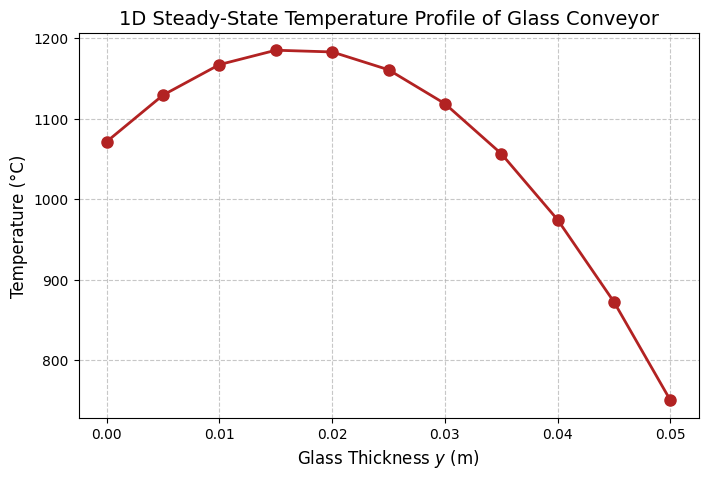

Top Surface Temp:    750.01 °C
Center Temp:         1160.71 °C
Bottom Surface Temp: 1071.41 °C


In [6]:
# --- Orchestrator ---
class SteadyStateSolver:
    """Executes the method-level contracts and solves the system."""
    def __init__(self, mesh, operators, bcs):
        self.mesh = mesh
        self.operators = operators
        self.bcs = bcs

    def solve(self, T_field):
        sys = LinearSystem(self.mesh.Nc)

        for op in self.operators:
            op.assemble(sys)

        for bc in self.bcs:
            bc.apply(sys)

        A, b = sys.to_csr()
        x = spla.spsolve(A, b)
        T_field.values[:] = x

# --- Execution Script ---
H, w, L = 0.05, 1.0, 2.0
N = 10
k = 1.05
m_dot, Cp = 0.5, 840
Ti, Tf = 800, 600
emiss =0.7

h_top, T1 = 40.0, 30.0
h_bot, T2 = 25.0, 30.0

# Instantiate Architecture
mesh = Mesh1D(N, H)
geo = Geometry1D(mesh, w, L)
T = Field(mesh, name="Temperature")
mat = Material(k=k)

op_diff = DiffusionOperator(mesh, geo, mat)
op_source = ConveyorSourceOperator(geo, m_dot, Cp, Ti, Tf)
T_avg_guess = (Ti + Tf) / 2.0
bc_top = MixedBC("top", T_amb=303.15, h=40.0, epsilon=emiss, T_guess=T_avg_guess, mesh=mesh, geo=geo)
T_avg_guess = (Ti + Tf) / 2.0
bc_bot = MixedBC("bottom", T_amb=303.15, h=0.0, epsilon=emiss, T_guess=T_avg_guess, mesh=mesh, geo=geo)


# Solve
solver = SteadyStateSolver(mesh, operators=[op_diff, op_source], bcs=[bc_bot, bc_top])
solver.solve(T)

# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(geo.y, T.values, 'o-', color='firebrick', linewidth=2, markersize=8)
plt.xlabel('Glass Thickness $y$ (m)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('1D Steady-State Temperature Profile of Glass Conveyor', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Top Surface Temp:    {T.values[-1]:.2f} °C")
print(f"Center Temp:         {T.values[N//2]:.2f} °C")
print(f"Bottom Surface Temp: {T.values[0]:.2f} °C")

## Inverse Problem: Target-Driven Optimization

In many engineering scenarios, we need to determine the required operating conditions (causes) to achieve a desired thermal state (effect). This is known as an inverse problem.

**Goal** Our goal is to find the exact boundary condition parameter—whether it is the top/bottom heat transfer coefficient ($h$) or the top/bottom ambient temperature ($T_{amb}$)—required to "hit" a specific temperature physical output. This output is one of the following:

1. ***Temperature gradient in the upper half of the glass***.


We define the target gradient as:
$$\text{Gradient} = \frac{T_{top} - T_{center}}{H/2}$$

2. ***Temperature of the top surface of the glass***

$$T_{top}$$

3. ***Temperature of the center of the glass***

$$T_{center}$$

**The OOP Strategy:**
Following our strict separation of concerns, the inverse solver does not rewrite any physics . Instead, the `InverseSolver` acts as a manager:
1. It accepts a "knob" (a string indicating which parameter to change).These parameters include **Temperature of top plate**, **temperature of bottom plate**, **htc of top surface**, **htc of bottom surface**.
2. It uses `scipy.optimize.minimize` to guess new values for that parameter.
3.For each guess, it updates the specific `MixedBC` object and runs the `SteadyStateSolver` [cite: 153, 202-207].
4. It calculates the resulting output (gradient, top temperature, center temperature) and computes the squared error against the target. SciPy minimizes this error to zero.

In [7]:
import scipy.optimize as opt

class InverseSolver:
    """Wraps the forward FVM solver in an optimization loop to target a specific thermal metric."""
    def __init__(self, forward_solver, field, bc_top, bc_bot, H, N):
        self.forward_solver = forward_solver
        self.field = field
        self.bc_top = bc_top
        self.bc_bot = bc_bot
        self.H = H
        self.N = N

    def _update_knob(self, knob, guess_value):
        """Routes the optimizer's guess to the correct physical boundary condition."""
        if knob == "h_top":
            self.bc_top.h = guess_value
        elif knob == "h_bot":
            self.bc_bot.h = guess_value
        elif knob == "T_amb_top":
            self.bc_top.T_amb = guess_value
        elif knob == "T_amb_bot":
            self.bc_bot.T_amb = guess_value
        else:
            raise ValueError(f"Unknown knob: {knob}. Choose from: h_top, h_bot, T_amb_top, T_amb_bot")

    def _objective_function(self, guess_array, knob, target_type, target_value):
        """The loss function SciPy will try to minimize to zero."""
        guess_value = guess_array[0]

        # 1. Turn the knob
        self._update_knob(knob, guess_value)

        # 2. Run the forward physics solver
        self.forward_solver.solve(self.field)

        # 3. Extract relevant temperatures
        T_top = self.field.values[-1]
        T_center = self.field.values[self.N // 2]

        # 4. Calculate current value based on the chosen target type
        if target_type == "gradient":
            current_value = (T_top - T_center) / (self.H / 2.0)
        elif target_type == "T_top":
            current_value = T_top
        elif target_type == "T_center":
            current_value = T_center
        else:
            raise ValueError("Unknown target_type. Choose: 'gradient', 'T_top', or 'T_center'")

        # 5. Return the squared error
        error = (current_value - target_value)**2
        return error

    def optimize(self, knob, target_type, target_value, initial_guess):
        """Executes the SciPy minimization routine."""
        print(f"--- Starting Optimization ---")
        print(f"Targeting {target_type}: {target_value:.2f}")
        print(f"Adjusting Parameter: '{knob}'\n")

        # Run SciPy Minimize
        result = opt.minimize(
            self._objective_function,
            x0=[initial_guess],
            args=(knob, target_type, target_value),
            method='Nelder-Mead'
        )

        if result.success:
            optimal_value = result.x[0]
            # Ensure the solver is run one final time with the optimal value
            self._update_knob(knob, optimal_value)
            self.forward_solver.solve(self.field)

            # Recalculate final value for verification
            T_top = self.field.values[-1]
            T_center = self.field.values[self.N // 2]

            if target_type == "gradient":
                final_val = (T_top - T_center) / (self.H / 2.0)
                unit = "°C/m"
            elif target_type == "T_top":
                final_val = T_top
                unit = "°C"
            else:
                final_val = T_center
                unit = "°C"

            print(f"Optimization Successful!")
            print(f"Optimal '{knob}' = {optimal_value:.4f}")
            print(f"Achieved {target_type} = {final_val:.2f} {unit}")
            return optimal_value
        else:
            print("Optimization failed to converge.")
            return None

### Running the Inverse Problem
We will now define a target gradient and choose which parameter to optimize. For this example, we will target a gradient of **-4000 °C/m** (meaning the top surface is significantly cooler than the core) by dynamically asking the solver to find the required **top ambient temperature (`T_amb_top`)**.

--- Starting Optimization ---
Targeting T_center: 700.00
Adjusting Parameter: 'h_bot'

Optimization Successful!
Optimal 'h_bot' = 419.3430
Achieved T_center = 700.00 °C


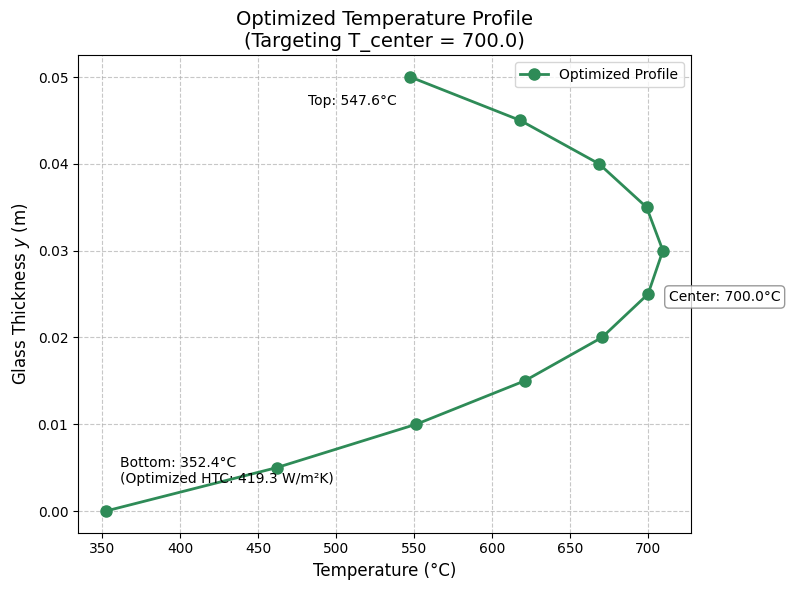

In [8]:
# --- Inverse Problem Setup ---
target_val = 700.0           # The numeric value we want to hit
target_type = "T_center"     # The output we care about ("gradient", "T_top", or "T_center")
knob_to_turn = "h_bot"       # The parameter SciPy will tweak ("h_top", "h_bot", "T_amb_top", or "T_amb_bot")
initial_guess = 50.0         # A starting guess for the bottom HTC

# Initialize the Inverse Solver
optimizer = InverseSolver(solver, T, bc_top, bc_bot, H, N)

# Run Optimization
optimal_knob_val = optimizer.optimize(
    knob=knob_to_turn,
    target_type=target_type,
    target_value=target_val,
    initial_guess=initial_guess
)

# --- Generate Result Plot ---
plt.figure(figsize=(8, 6))

# Plot the newly optimized temperature profile
plt.plot(T.values, geo.y, 'o-', color='seagreen', linewidth=2, markersize=8, label='Optimized Profile')

plt.ylabel('Glass Thickness $y$ (m)', fontsize=12)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.title(f'Optimized Temperature Profile\n(Targeting {target_type} = {target_val})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotations to show the results
plt.annotate(f"Top: {T.values[-1]:.1f}°C",
             xy=(T.values[-1], geo.y[-1]), xytext=(-10, -20), textcoords='offset points',
             ha='right', color='black')

plt.annotate(f"Center: {T.values[N//2]:.1f}°C",
             xy=(T.values[N//2], geo.y[N//2]), xytext=(15, -5), textcoords='offset points',
             ha='left', color='black', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.annotate(f"Bottom: {T.values[0]:.1f}°C\n(Optimized HTC: {bc_bot.h:.1f} W/m²K)",
             xy=(T.values[0], geo.y[0]), xytext=(10, 20), textcoords='offset points',
             ha='left', color='black')

plt.legend()
plt.tight_layout()
plt.show()